### Computer Simulation Project

**Name** : Sadegh Moahmmadian

**Student Number** : 401109477

### Libraries

In [16]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [17]:
class Patient:
    def __init__(self, t_arrival, disability_type, dest):
        self.t_arrival = t_arrival
        self.disability_type = disability_type
        self.dest = dest
        

In [18]:
class Server:
    def __init__(self, robot_pres=False, alpha=1.0, p_error=0.0):
        self.robot_pres = robot_pres
        self.alpha = alpha
        self.p_error = p_error
        self.full_until = 0

    def serve(self, patient, clock):
        
        if patient.disability_type:
            disability = patient.disability_type
        else:
            disability = 'None'
            
        t_service = {
            1: {'A': 8, 'B': 10},
            2: {'A': 10, 'B': 14},
            3: {'A': 18, 'B': 16},
            'None': {'A': 4, 'B': 6}
        }

        time = t_service[disability][patient.dest]
        
        if self.robot_pres and disability != 'None':
            service_time = time * self.alpha
        else:
            service_time = time

        # Add error-related delays
        if self.p_error != 0:
            errors = np.random.geometric(self.p_error) - 1
        else:
            errors = 0

        total_service_time = service_time * (1 + errors)
        self.full_until = clock + total_service_time
        
        return total_service_time



In [19]:
class Simulation:
    def __init__(self, t_total, arrival_rate, disability_prob, dest_prob, alpha, p_error, robot_pres):
        self.t_total = t_total
        self.arrival_rate = arrival_rate
        self.disability_prob = disability_prob
        self.dest_prob = dest_prob
        self.alpha = alpha
        self.p_error = p_error
        self.robot_pres = robot_pres
        self.patients = []
        self.count_diable_patient = 0
        self.count_not_disable_patient = 0
        self.serv_time_server1 = 0
        self.serv_time_server2 = 0

        self.first_server = Server(robot_pres=False, p_error=p_error)
        self.second_server = Server(robot_pres=robot_pres, alpha=alpha, p_error=p_error)
        

    def patient_generator(self):
        clock = 0
        while clock < self.t_total:
            inter_t_arrival = np.random.exponential(1 / self.arrival_rate)
            clock += inter_t_arrival

            disability = random.choices([1, 2, 3, 'None'], weights=[self.disability_prob/3, self.disability_prob/3, self.disability_prob/3, 1 - self.disability_prob])[0]
            dest = random.choices(['A', 'B'], weights=[self.dest_prob, 1 - self.dest_prob])[0]
            self.patients.append(Patient(clock, disability, dest))



    def run(self):
        first_Q = []
        second_Q = []
        clock = 0
        wait_times = []
        wait_times_disable = []
        wait_times_able = []
        t_service = []
        t_service_disable = []
        t_service_able = []

        for patient in self.patients:
            # Fast-forward time
            clock = max(clock, patient.t_arrival)
            if patient.disability_type == 'None':
                self.count_not_disable_patient +=1
            # Add patient to the queue
                if len(second_Q) == len(first_Q):
                    rand_q = random.choices([1, 2])[0]
                    if rand_q == 1:
                        first_Q.append(patient)    
                    else:
                        second_Q.append(patient)

                
                elif len(second_Q) > len(first_Q):
                    first_Q.append(patient)
                else:
                    second_Q.append(patient)

            else:
                self.count_diable_patient += 1
                second_Q.append(patient)

            # Serve patients
            while (first_Q and clock >= self.first_server.full_until):
                patient_to_serve = first_Q.pop(0)
                server = self.first_server

                wait_times.append(max(server.full_until,patient_to_serve.t_arrival) - patient_to_serve.t_arrival) # wait or go?
                wait_times_able.append(max(server.full_until,patient_to_serve.t_arrival) - patient_to_serve.t_arrival)
                service_time = server.serve(patient_to_serve, max(server.full_until,patient_to_serve.t_arrival))
                
                t_service.append(service_time)
                t_service_able.append(service_time)
                clock += service_time
                self.serv_time_server1 += service_time

            while  (second_Q and clock >= self.second_server.full_until):
                
                
                server = self.second_server
                patient_is_disable = True

                if not self.robot_pres:
                    patient_to_serve = second_Q.pop(0)
                else:
                    disable_index = None
                    for i , patient in enumerate(second_Q):
                        if patient.disability_type != 'None':
                            disable_index = i
                            break
                    if disable_index is not None:
                        patient_to_serve = second_Q.pop(disable_index)
                        patient_is_disable = True
                    else:
                        patient_to_serve = second_Q.pop(0)
                        patient_is_disable = False
                
                wait_times.append(max(server.full_until,patient_to_serve.t_arrival) - patient_to_serve.t_arrival)
                service_time = server.serve(patient_to_serve, max(server.full_until,patient_to_serve.t_arrival))
                t_service.append(service_time)
                clock += service_time
                self.serv_time_server2 += service_time

                if patient_is_disable:
                    t_service_disable.append(service_time)
                    wait_times_disable.append(max(server.full_until,patient_to_serve.t_arrival) - patient_to_serve.t_arrival)
                else:
                    t_service_able.append(service_time)
                    wait_times_able.append(max(server.full_until,patient_to_serve.t_arrival) - patient_to_serve.t_arrival)



        # Calculate metrics
        metrics = {
            'average_wait_time(W_q)': np.mean(wait_times),
            'average_service_time(S)': np.mean(t_service),
            'average_queue_length(L_q)': np.sum(wait_times)/(2*clock),
            'average_t_total_in_system(W)': np.mean(wait_times) + np.mean(t_service),
            'count_disable_patient' : self.count_diable_patient,
            'count_not_disable_patient' : self.count_not_disable_patient,
            'average_t_total_in_system_able': np.mean(wait_times_able) + np.mean(t_service_able),
            'average_t_total_in_system_disable': np.mean(wait_times_disable) + np.mean(t_service_disable),
            'server1_utilization': self.serv_time_server1/clock,
            'server2_utilization': self.serv_time_server2/clock,

        }
        
        return metrics

### Runing Simulation

In [20]:
arrival_rate = 1/8
t_total = 8*60
disability_prob = 0.4
alpha=0.8
p_error=0.0
dest_prob = 1.0
num_runs = 1000


total_metrics = {'average_wait_time(W_q)': 0, 'average_service_time(S)': 0, 'average_queue_length(L_q)': 0, 'average_t_total_in_system(W)': 0 , 'count_disable_patient' : 0, 'count_not_disable_patient' : 0, 'average_t_total_in_system_able': 0, 'average_t_total_in_system_disable': 0, 'server1_utilization': 0, 'server2_utilization': 0}

for _ in range(num_runs):
    simulation = Simulation(
        t_total=t_total,
        arrival_rate=arrival_rate,
        disability_prob=disability_prob,
        dest_prob=dest_prob,
        alpha=alpha,
        p_error=p_error,
        robot_pres=True
    )
    simulation.patient_generator()
    metrics = simulation.run()
    for key in total_metrics:
        total_metrics[key] += metrics[key]

average_metrics = {}
for key, value in total_metrics.items():
    average_metrics.update({key: value / num_runs})

print(f'Metrics After {num_runs} runs with robotic server:')

for key, value in average_metrics.items():
    print(f'{key} = {value}')


total_metrics2 = {'average_wait_time(W_q)': 0, 'average_service_time(S)': 0, 'average_queue_length(L_q)': 0, 'average_t_total_in_system(W)': 0 , 'count_disable_patient' : 0, 'count_not_disable_patient' : 0, 'average_t_total_in_system_able': 0, 'average_t_total_in_system_disable': 0, 'server1_utilization': 0, 'server2_utilization': 0}

for _ in range(num_runs):
    simulation = Simulation(
        t_total=t_total,
        arrival_rate=arrival_rate,
        disability_prob=disability_prob,
        dest_prob=dest_prob,
        alpha=alpha,
        p_error=p_error,
        robot_pres=False
    )
    simulation.patient_generator()
    metrics = simulation.run()
    for key in total_metrics2:
        total_metrics2[key] += metrics[key]

average_metrics = {}
for key, value in total_metrics2.items():
    average_metrics.update({key: value / num_runs})

print(f'\nMetrics After {num_runs} runs without robotic server:')


for key, value in average_metrics.items():
    print(f'{key} = {value}')

Metrics After 1000 runs with robotic server:
average_wait_time(W_q) = 4.94818752220402
average_service_time(S) = 6.252116681104227
average_queue_length(L_q) = 0.308253607035915
average_t_total_in_system(W) = 11.200304203308248
count_disable_patient = 24.496
count_not_disable_patient = 36.515
average_t_total_in_system_able = 9.71126844647809
average_t_total_in_system_disable = 25.873077814395717
server1_utilization = 0.14529567831774465
server2_utilization = 0.6109824096669623

Metrics After 1000 runs without robotic server:
average_wait_time(W_q) = 9.829104123273805
average_service_time(S) = 7.185739251444909
average_queue_length(L_q) = 0.5791116346205949
average_t_total_in_system(W) = 17.014843374718705
count_disable_patient = 24.229
count_not_disable_patient = 36.66
average_t_total_in_system_able = 4.3221610634718965
average_t_total_in_system_disable = 30.68156332890975
server1_utilization = 0.14028005202564217
server2_utilization = 0.6966330007847824


### Funtion to plot the effect of different parameters in Simulation Result

In [143]:

def plot_parameter_impact(param_name, param_values, simulation_params):
    metrics_to_plot = ['average_wait_time(W_q)', 'average_service_time(S)', 'average_queue_length(L_q)', 
                       'average_t_total_in_system(W)', 'count_disable_patient', 'count_not_disable_patient', 
                       'average_t_total_in_system_able', 'average_t_total_in_system_disable', 
                       'server1_utilization', 'server2_utilization']

    results = {metric: [] for metric in metrics_to_plot}

    for value in param_values:
        simulation_params[param_name] = value

        total_metrics = {metric: 0 for metric in metrics_to_plot}
        for _ in range(simulation_params['num_runs']):
            simulation = Simulation(
                t_total=simulation_params['t_total'],
                arrival_rate=simulation_params['arrival_rate'],
                disability_prob=simulation_params['disability_prob'],
                dest_prob=simulation_params['dest_prob'],
                alpha=simulation_params['alpha'],
                p_error=simulation_params['p_error'],
                robot_pres=True
            )
            simulation.patient_generator()
            metrics = simulation.run()
            for key in total_metrics:
                total_metrics[key] += metrics[key]

        average_metrics = {key: value / simulation_params['num_runs'] for key, value in total_metrics.items()}

        for metric in metrics_to_plot:
            results[metric].append(average_metrics[metric])


    num_cols = 5
    num_rows = -(-len(metrics_to_plot) // num_cols)  
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    axes = axes.flatten()

    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i]
        ax.plot(param_values, results[metric], marker='o')
        ax.set_title(metric)
        ax.set_xlabel(param_name)
        ax.set_ylabel(metric)
        ax.grid(True)

    # Hide unused subplots
    for i in range(len(metrics_to_plot), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()


### Arrival_rate effect

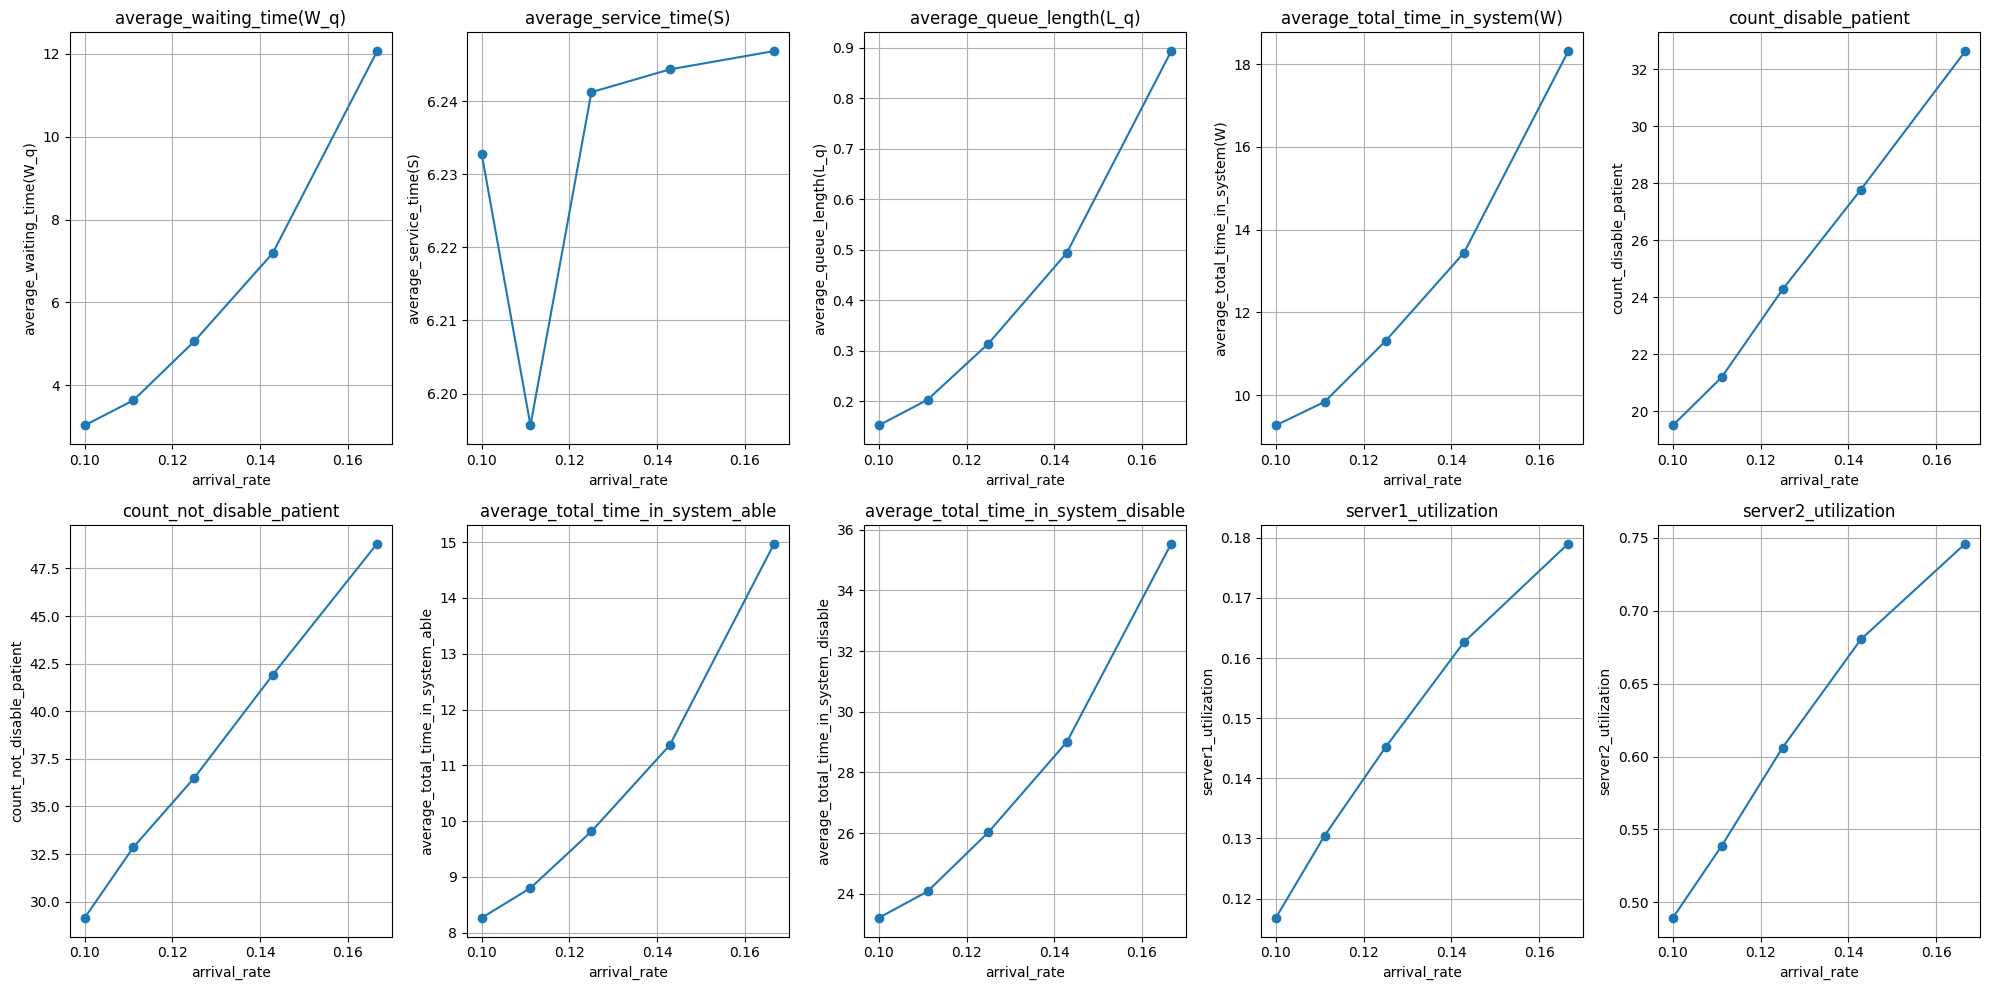

In [144]:

# Example usage
simulation_params = {
    'arrival_rate': 1/8,
    't_total': 8 * 60,
    'disability_prob': 0.4,
    'alpha': 0.8,
    'p_error': 0.0,
    'dest_prob': 1.0,
    'num_runs': 1000
}

param_name = 'arrival_rate'
param_values = [1/10, 1/9, 1/8, 1/7, 1/6]
plot_parameter_impact(param_name, param_values, simulation_params)

### Total-Time effect

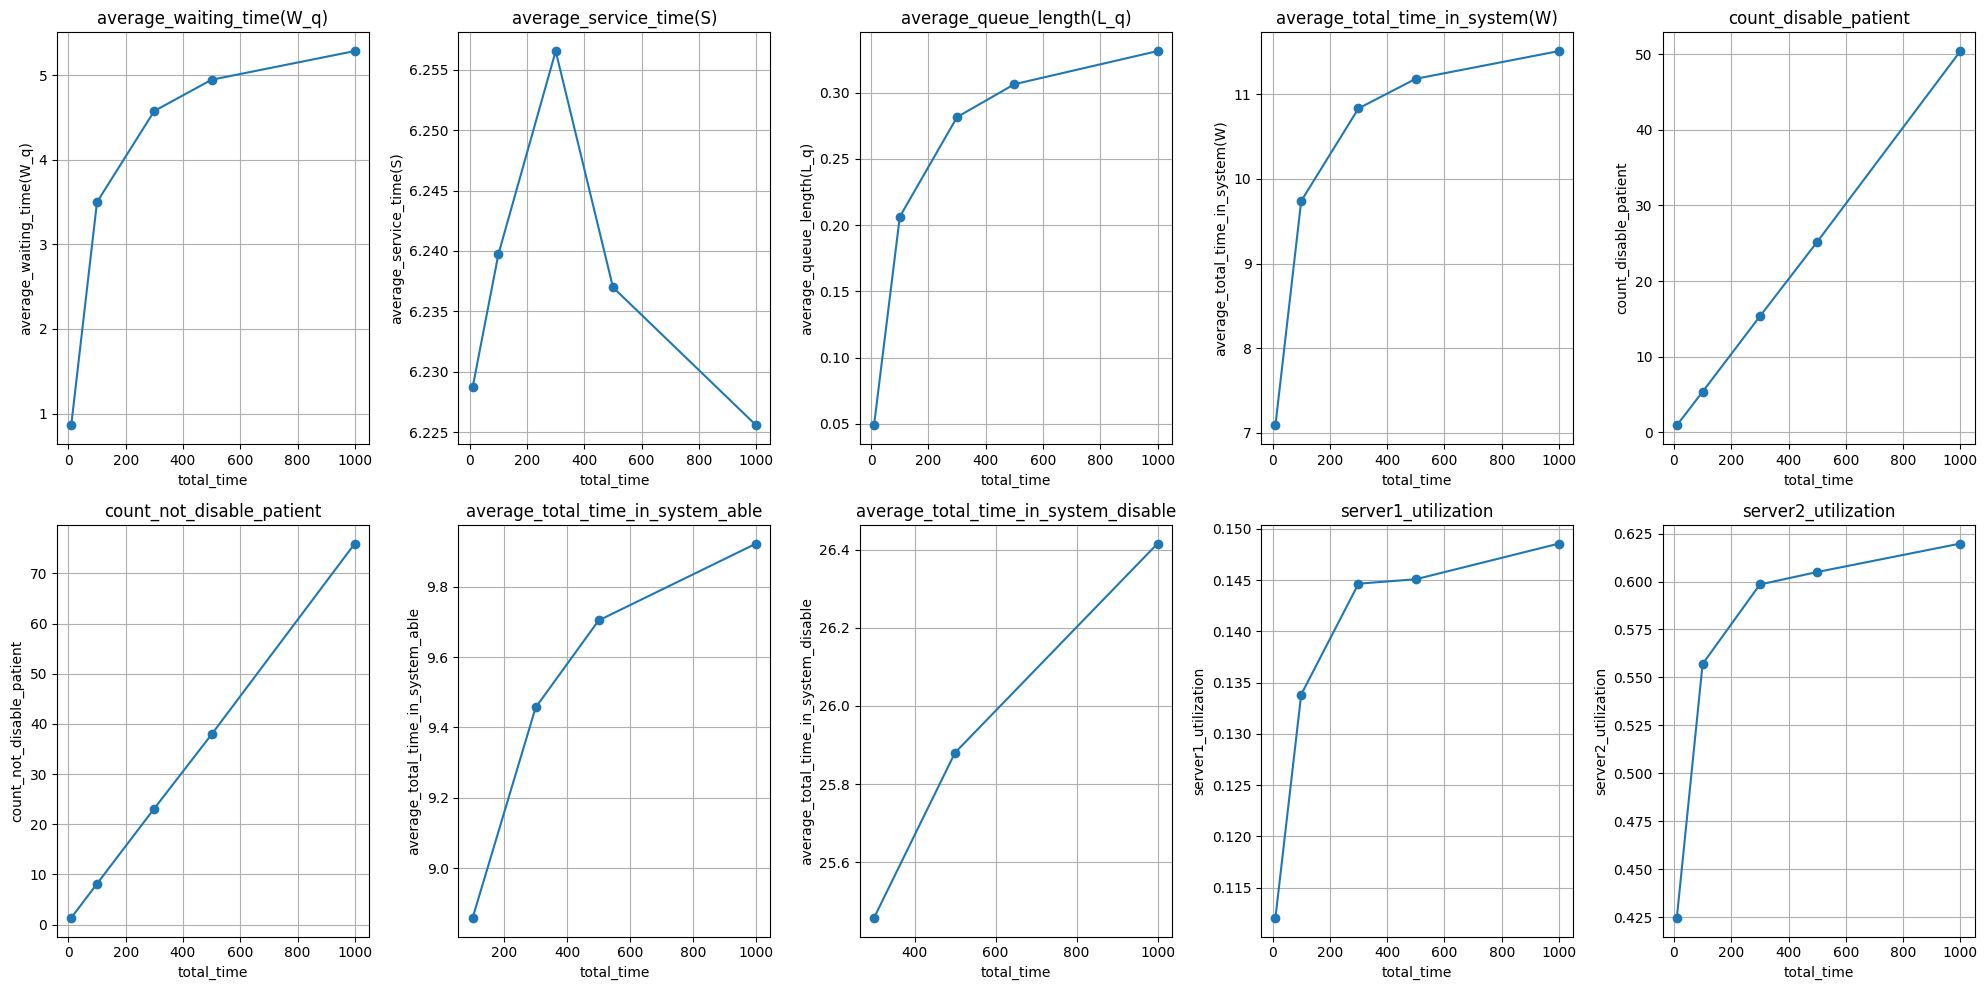

In [145]:
# Example usage
simulation_params = {
    'arrival_rate': 1/8,
    't_total': 8 * 60,
    'disability_prob': 0.4,
    'alpha': 0.8,
    'p_error': 0.0,
    'dest_prob': 1.0,
    'num_runs': 1000
}

param_name = 't_total'
param_values = [10, 100, 300, 500, 1000]
plot_parameter_impact(param_name, param_values, simulation_params)

### Disability_Prob effect

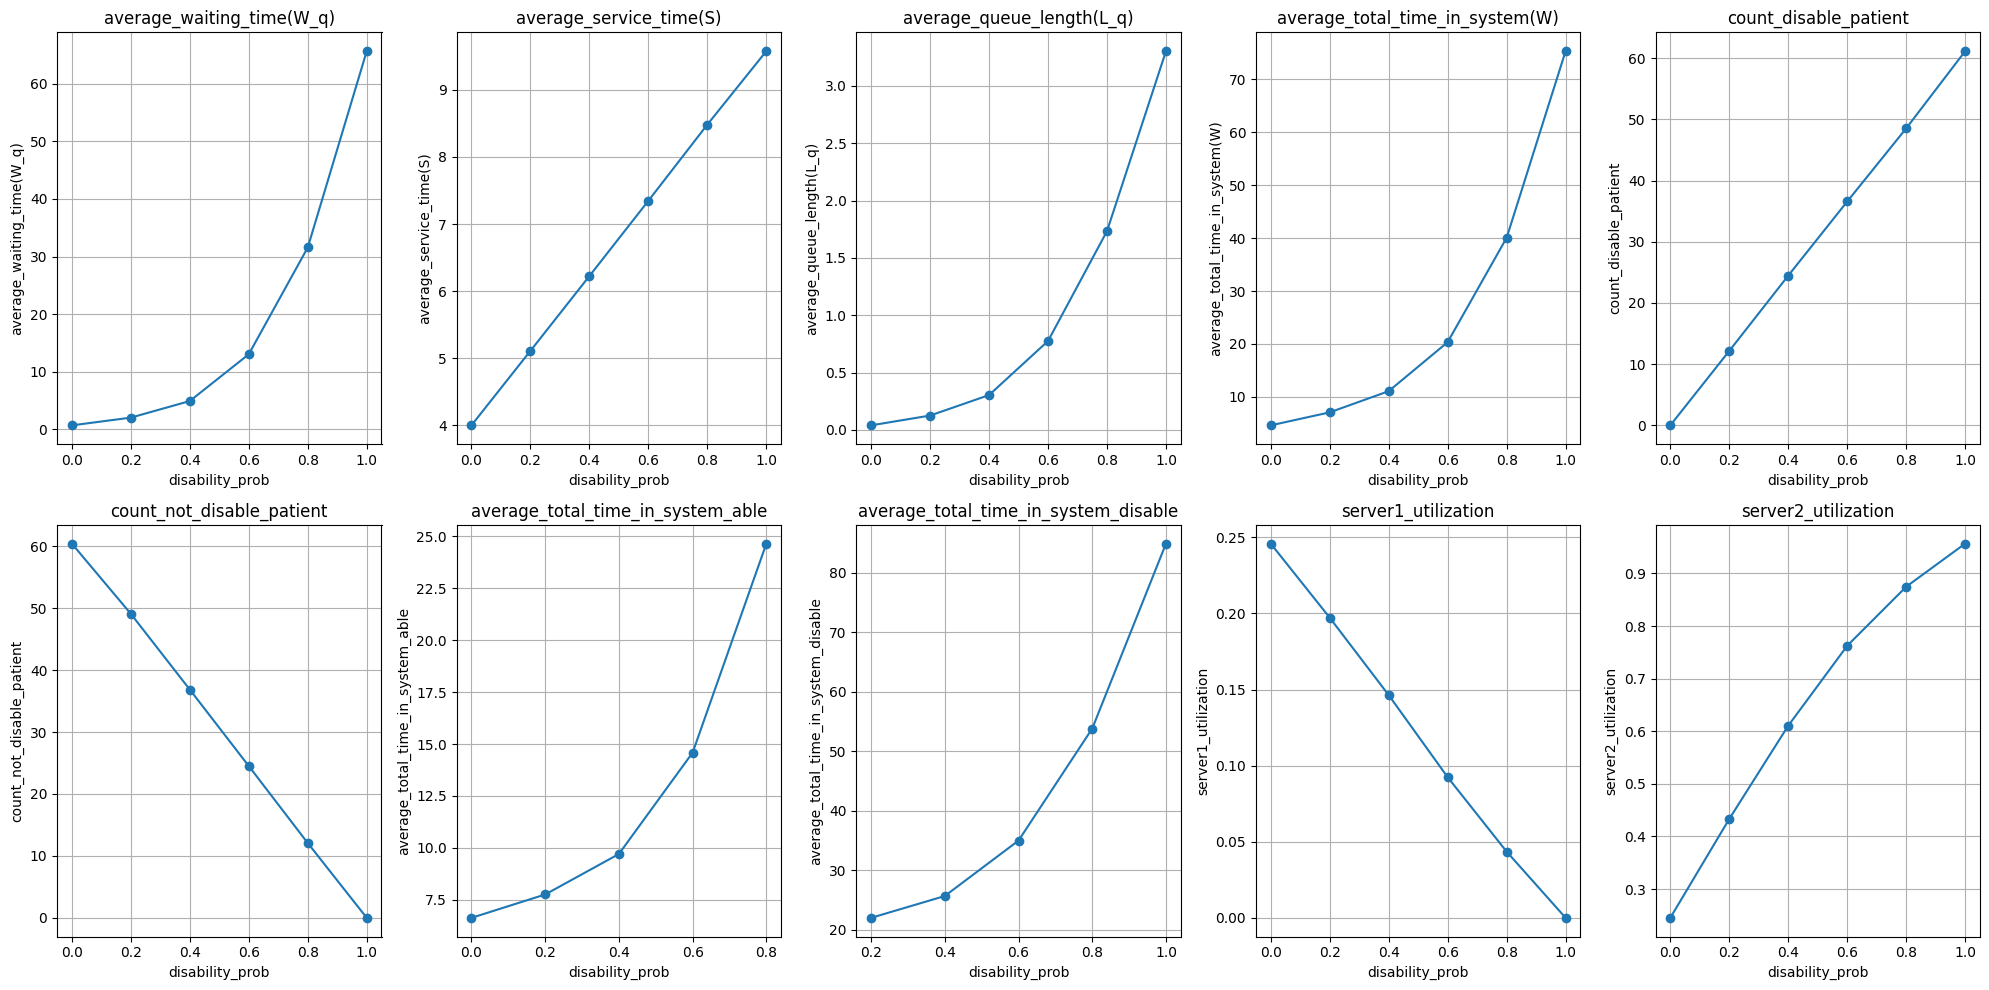

In [146]:
# Example usage
simulation_params = {
    'arrival_rate': 1/8,
    't_total': 8 * 60,
    'disability_prob': 0.4,
    'alpha': 0.8,
    'p_error': 0.0,
    'dest_prob': 1.0,
    'num_runs': 1000
}

param_name = 'disability_prob'
param_values = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
plot_parameter_impact(param_name, param_values, simulation_params)

### Robot_alpha_prob

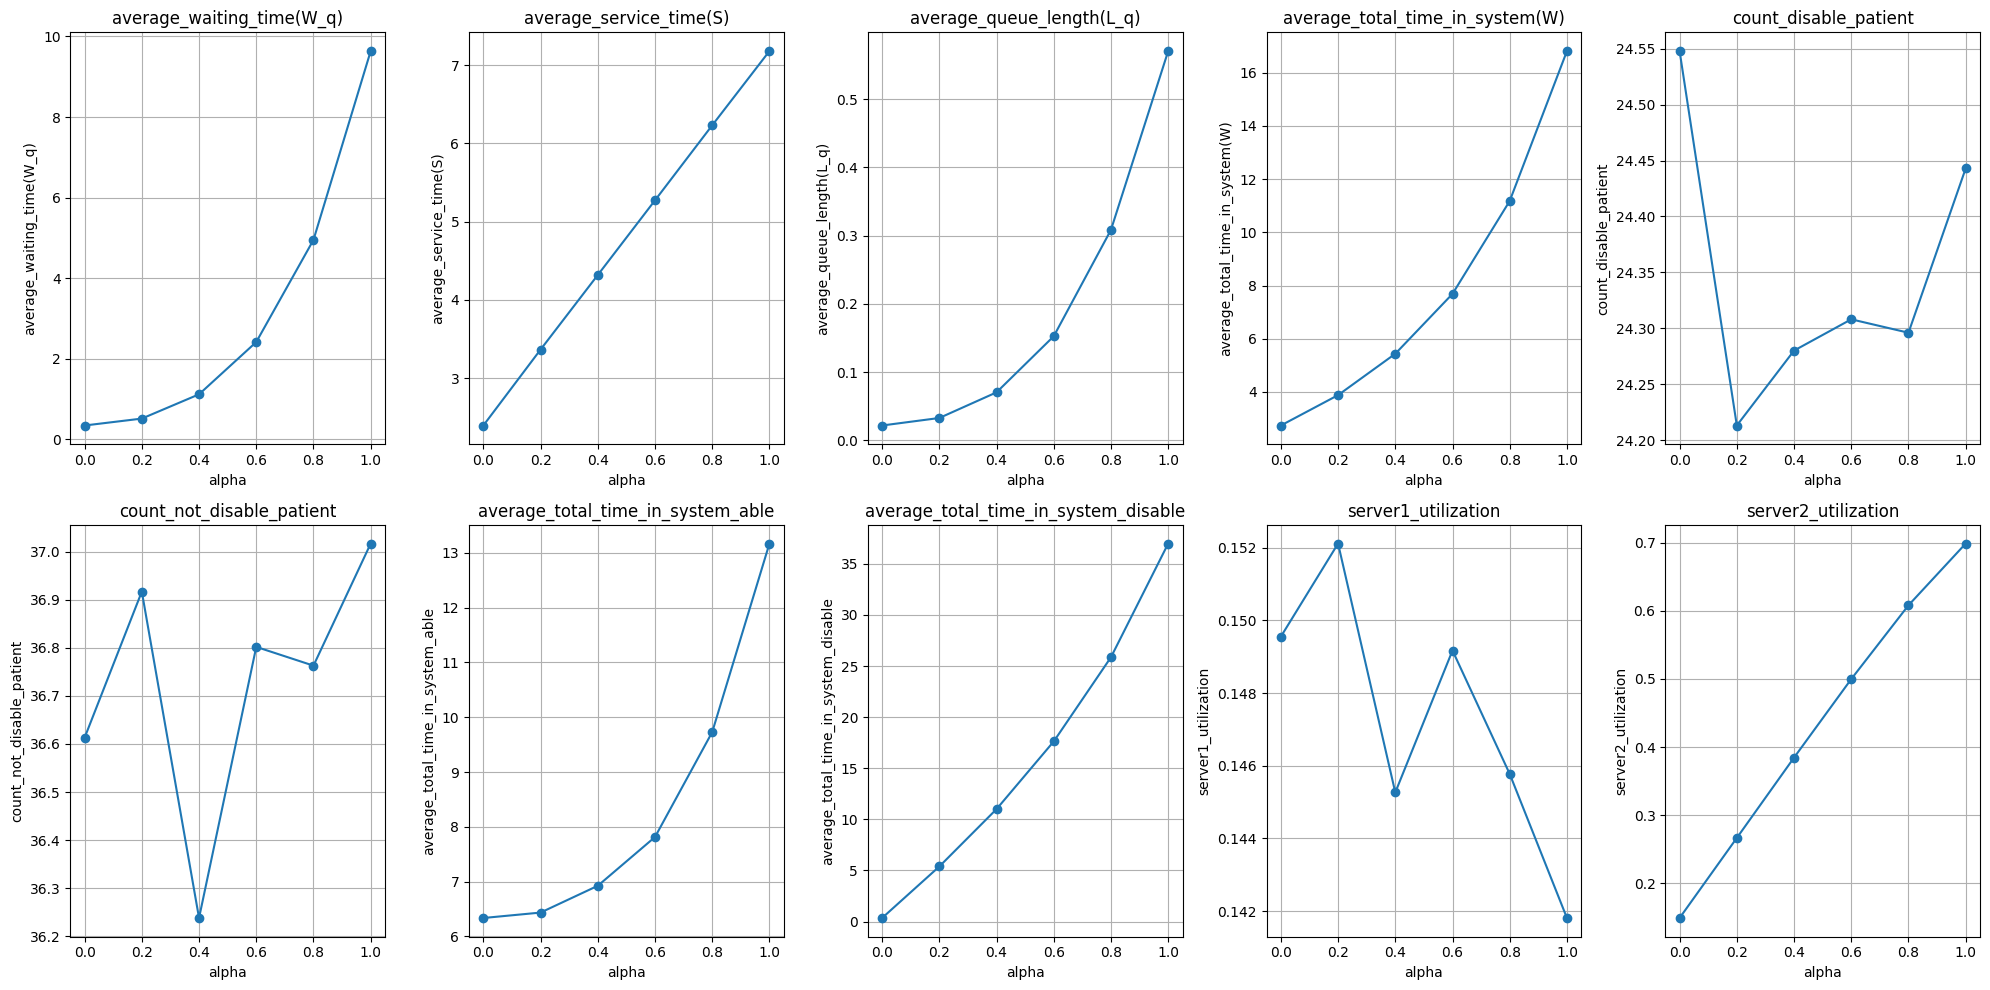

In [147]:
# Example usage
simulation_params = {
    'arrival_rate': 1/8,
    't_total': 8 * 60,
    'disability_prob': 0.4,
    'alpha': 0.8,
    'p_error': 0.0,
    'dest_prob': 1.0,
    'num_runs': 1000
}

param_name = 'alpha'
param_values = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
plot_parameter_impact(param_name, param_values, simulation_params)

### Error_prob Effect

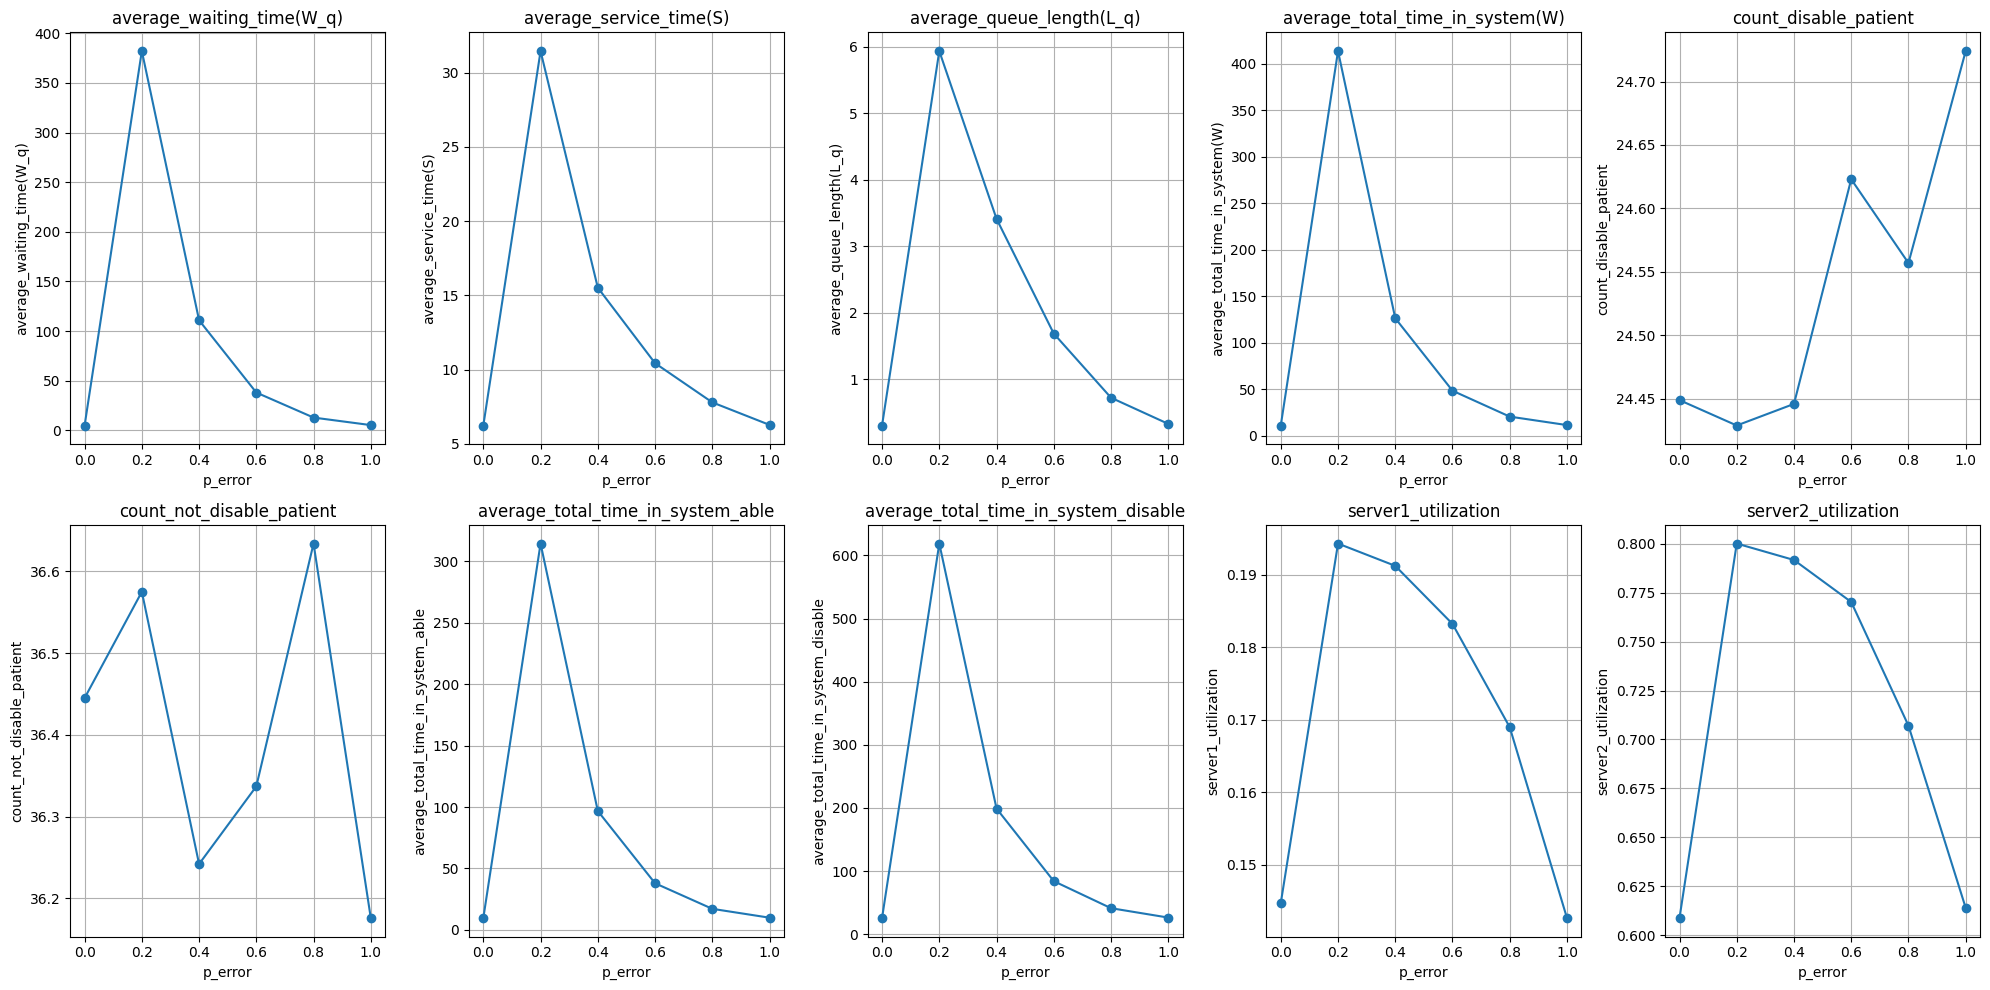

In [148]:
# Example usage
simulation_params = {
    'arrival_rate': 1/8,
    't_total': 8 * 60,
    'disability_prob': 0.4,
    'alpha': 0.8,
    'p_error': 0.0,
    'dest_prob': 1.0,
    'num_runs': 1000
}

param_name = 'p_error'
param_values = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
plot_parameter_impact(param_name, param_values, simulation_params)

### Destination_prob Effect

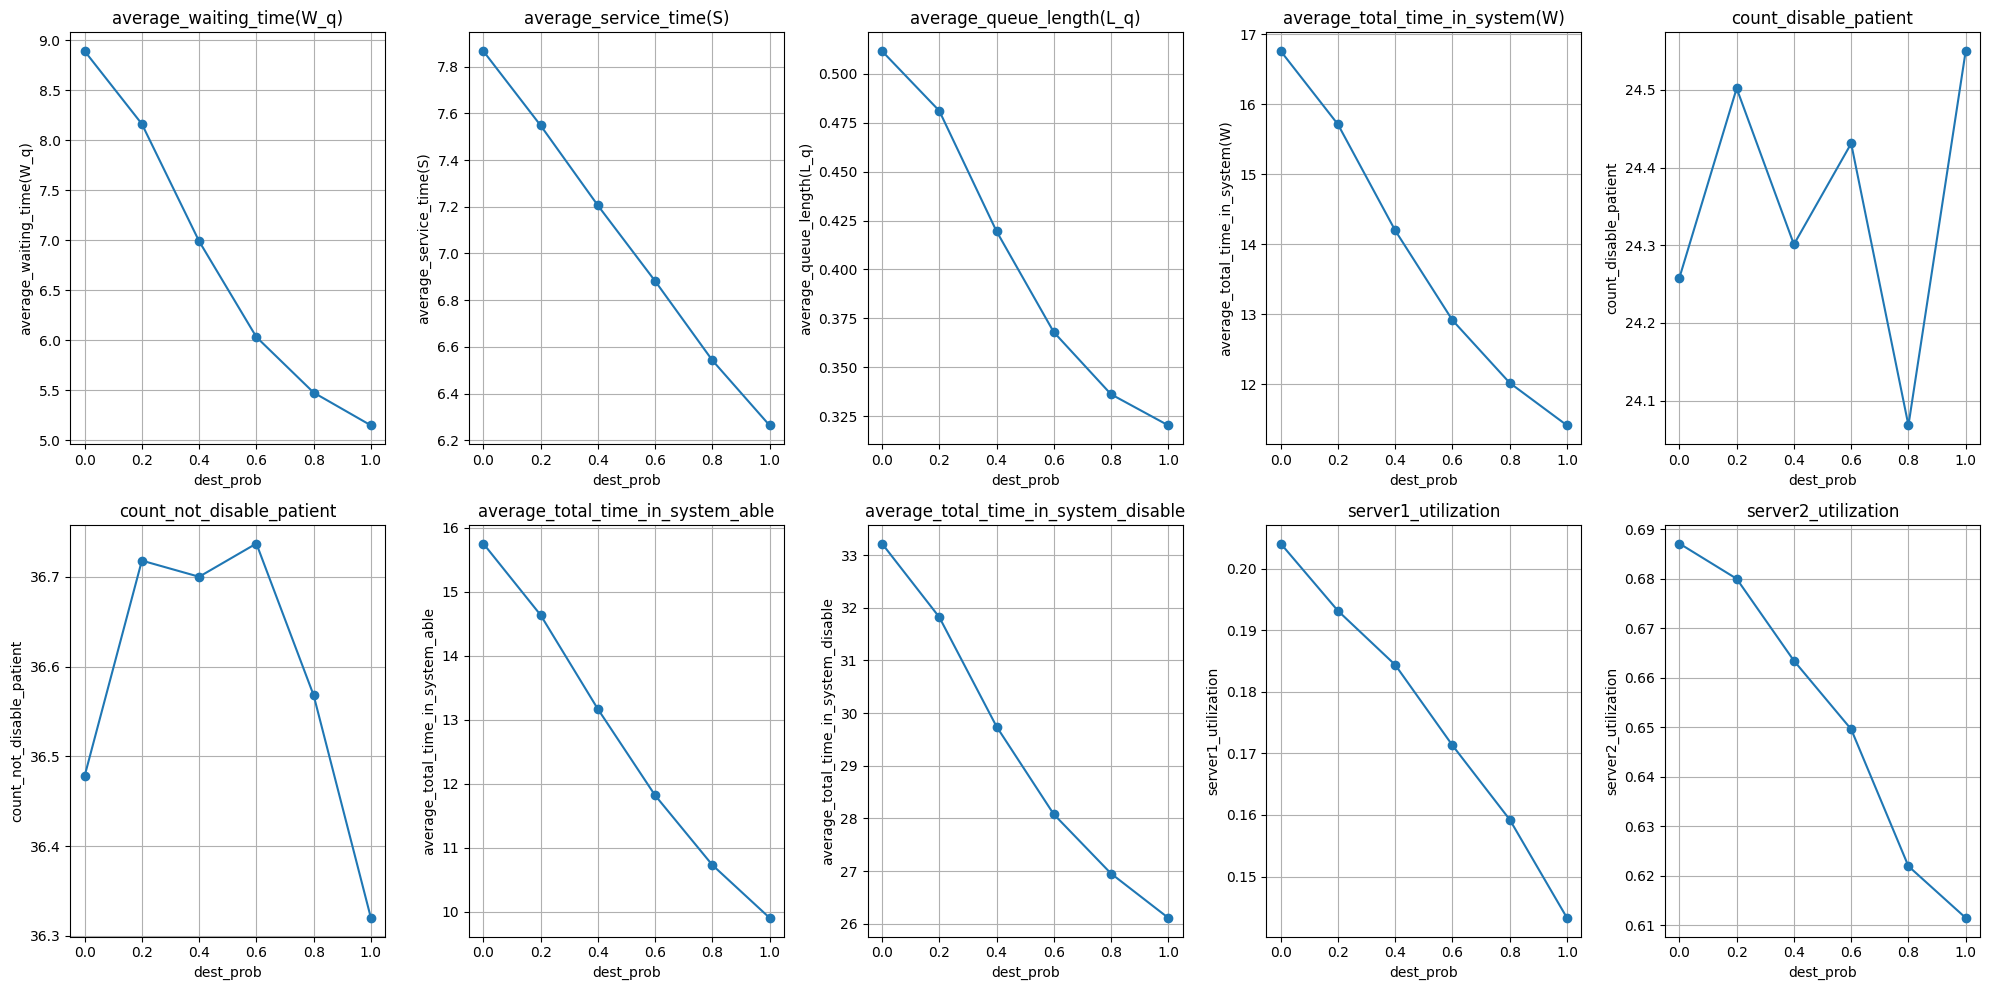

In [149]:
# Example usage
simulation_params = {
    'arrival_rate': 1/8,
    't_total': 8 * 60,
    'disability_prob': 0.4,
    'alpha': 0.8,
    'p_error': 0.0,
    'dest_prob': 1.0,
    'num_runs': 1000
}

param_name = 'dest_prob'
param_values = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
plot_parameter_impact(param_name, param_values, simulation_params)